In [1]:
!pip install datasets transformers matplotlib

import torch
import torch.nn as nn
import math
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import time


In [2]:
# Load WikiText-2
ds = load_dataset("wikitext", "wikitext-2-raw-v1")

train_text = "\n\n".join(ds["train"]["text"])
val_text   = "\n\n".join(ds["validation"]["text"])

# Use GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
def make_blocks(text, tokenizer, block_size=256):
    ids = tokenizer(text)["input_ids"]
    n = len(ids)
    n = (n // block_size) * block_size  # trim
    ids = ids[:n]
    data = torch.tensor(ids, dtype=torch.long)
    return data.view(-1, block_size)

block_size = 128  # fast for Colab

train_blocks = make_blocks(train_text, tokenizer, block_size)
val_blocks   = make_blocks(val_text, tokenizer, block_size)

train_ds = TensorDataset(train_blocks[:, :-1], train_blocks[:, 1:])
val_ds   = TensorDataset(val_blocks[:, :-1],   val_blocks[:, 1:])


Token indices sequence length is longer than the specified maximum sequence length for this model (2428601 > 1024). Running this sequence through the model will result in indexing errors


In [4]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)


In [5]:
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        B, T, C = x.size()
        pos = torch.arange(T, device=x.device).unsqueeze(0)
        return x + self.pe(pos)


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)


In [6]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, lora_r=0):
        super().__init__()
        assert d_model % n_heads == 0

        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.attention_weights = None

        # base linear layers
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # wrap with LoRA if requested
        if lora_r > 0:
            self.qkv = LoRALinear(self.qkv, r=lora_r)
            self.out_proj = LoRALinear(self.out_proj, r=lora_r)

    def forward(self, x):
        B, T, C = x.size()

        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)

        # split into heads
        def split(t):
            return t.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        q, k, v = split(q), split(k), split(v)

        # causal attention
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1)
        att = att.masked_fill(mask == 1, float('-inf')).softmax(dim=-1)

        self.attention_weights = att[0, 0].cpu().detach()

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        return self.out_proj(y)


In [7]:
class Block(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout, lora_r=0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, lora_r=lora_r)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.ln1(x)))
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x


In [8]:
class TinyGPT(nn.Module):
    def __init__(
        self, vocab_size, d_model=256, n_layers=4,
        n_heads=4, d_ff=1024, max_len=128,
        dropout=0.1, pos_type="learned",
        lora_r=0
    ):
        super().__init__()

        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = LearnedPositionalEncoding(max_len, d_model) \
                       if pos_type=="learned" else \
                       SinusoidalPositionalEncoding(max_len, d_model)

        self.blocks = nn.ModuleList([
            Block(d_model, n_heads, d_ff, dropout, lora_r=lora_r)
            for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)


    def forward(self, x, targets=None):
        h = self.tok_emb(x)
        h = self.pos_emb(h)
        for blk in self.blocks:
            h = blk(h)
        h = self.ln_f(h)
        logits = self.head(h)

        loss = None
        if targets is not None:
            loss = nn.functional.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-100
            )
        return logits, loss


In [9]:
class LoRALinear(nn.Module):
    def __init__(self, linear: nn.Linear, r=8, alpha=16):
        super().__init__()
        self.linear = linear
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r

        # LoRA parameters
        self.A = nn.Parameter(torch.zeros(r, linear.in_features))
        self.B = nn.Parameter(torch.zeros(linear.out_features, r))

        # initialize
        nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
        nn.init.zeros_(self.B)

        # freeze original
        for p in self.linear.parameters():
            p.requires_grad = False

    def forward(self, x):
        # x: (batch, seq_len, in_features)
        out = self.linear(x)                       # (batch, seq_len, out_features)
        lora_out = (x @ self.A.T) @ self.B.T * self.scaling  # same shape
        return out + lora_out


In [10]:
model_configs = [
    {"name": "small",  "d_model": 128, "n_layers": 2, "n_heads": 2, "d_ff": 512},
    {"name": "medium", "d_model": 256, "n_layers": 4, "n_heads": 4, "d_ff": 1024},
    {"name": "large",  "d_model": 384, "n_layers": 6, "n_heads": 6, "d_ff": 1536},
]


In [11]:
def count_parameters(model):
    """Returns total and trainable parameters."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [12]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model = TinyGPT(
#     vocab_size=len(tokenizer),
#     d_model=256, n_layers=4, n_heads=4,
#     d_ff=1024, max_len=block_size,
#     dropout=0.1,
#     pos_type="learned",  # <-- switch between "learned" and "sin" (experiment 1)
#     lora_r=8        #  <-- set to lora_r = 0 for full fine tuning (experiment 2)
# ).to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
def run_epoch(model, optimizer, loader, train=True):
    device = next(model.parameters()).device # Ensures the device is correctly identified
    model.train() if train else model.eval()

    total_loss, total_tokens = 0, 0

    # Use torch.no_grad() for evaluation phases to save memory and computation
    context = torch.enable_grad() if train else torch.no_grad()

    with context:
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            # The optimizer.zero_grad() is correctly placed here for per-batch updates
            if train:
                optimizer.zero_grad()

            # Forward pass: Assuming model returns (predictions, loss)
            _, loss = model(x, y)

            if train:
                # 1. Backpropagation (Calculates Gradients)
                loss.backward()

                # 2. Gradient Clipping (Recommended for Transformers)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                # 3. Parameter Update
                optimizer.step()

            # Accumulate loss and token count
            total_loss += loss.item() * x.numel()
            total_tokens += x.numel()

    return total_loss / total_tokens
# def run_epoch(model, optimizer, loader, train=True):
#     device = next(model.parameters()).device
#     model.train() if train else model.eval()

#     total_loss, total_tokens = 0, 0
#     for x, y in loader:
#         x, y = x.to(device), y.to(device)
#         if train: optimizer.zero_grad()

#         _, loss = model(x, y)

#         if train:
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()

#         total_loss += loss.item() * x.numel()
#         total_tokens += x.numel()

#     return total_loss / total_tokens

train_curve = []
val_curve = []


In [13]:
def run_experiment(config_name, d_model, n_layers, n_heads, d_ff, dropout, pos_type, lora_r, epochs=5):

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 1. MODEL INITIALIZATION
    model = TinyGPT(
        vocab_size=len(tokenizer),
        d_model=d_model, n_layers=n_layers, n_heads=n_heads,
        d_ff=d_ff, max_len=block_size,
        dropout=dropout,
        pos_type=pos_type,
        lora_r=lora_r
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

    # 2. PARAMETER LOGGING (Resource Usage Part 1)
    total_params, trainable_params = count_parameters(model)

    print(f"\n--- Starting Experiment: {config_name} ---")
    print(f"Trainable Params: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")

    # 3. TRAINING LOOP and METRIC COLLECTION
    train_curve, val_curve, max_mem_GB = [], [], []
    total_start_time = time.time()

    if device == "cuda":
        torch.cuda.empty_cache()

    for epoch in range(epochs):
        t0 = time.time()

        # We need a defined run_epoch function (use your existing one)
        train_loss = run_epoch(model, optimizer, train_loader, train=True)
        val_loss = run_epoch(model, optimizer, val_loader, train=False)

        elapsed = time.time() - t0
        train_curve.append(train_loss)
        val_curve.append(val_loss)

        # PEAK GPU MEMORY LOGGING (Resource Usage Part 2)
        current_max_memory = 0.0
        if device == "cuda":
            current_max_memory = torch.cuda.max_memory_allocated() / (1024**3)
            torch.cuda.reset_peak_memory_stats() # Reset after measurement
        max_mem_GB.append(current_max_memory)

        print(f"Epoch {epoch}: val {val_loss:.4f} | ppl {math.exp(val_loss):.1f} | time {elapsed:.1f}s | Mem Peak {current_max_memory:.2f}GB")

    total_time = time.time() - total_start_time
    avg_peak_mem = sum(max_mem_GB) / len(max_mem_GB) if max_mem_GB else 0
    final_ppl = math.exp(val_loss)

    # 4. RETURN ALL RESULTS
    results = {
        'config_name': config_name,
        'd_model': d_model,
        'n_layers': n_layers,
        'lora_r': lora_r,
        'pos_type': pos_type,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'final_val_ppl': final_ppl,
        'total_time_s': total_time,
        'avg_peak_mem_GB': avg_peak_mem,
        'train_curve': train_curve,
        'val_curve': val_curve
    }
    return results

In [14]:
# --- Common Parameters (Ensure these match your actual setup) ---
N_HEADS = 4
D_FF = 1024
DROPOUT = 0.1
EPOCHS = 5 # Adjust epochs as needed

all_results = []

print("Starting Comparative Experiments...")
print("-" * 30)

# ==========================================================
# --- 1. BASE MODEL (Medium, Full Fine-Tuning, Learned PE) ---
# This serves as the reference point (lora_r=0 means Full FT).
# ==========================================================
base_config = run_experiment(
    config_name="Base_Medium_FullFT",
    d_model=256, n_layers=4, n_heads=N_HEADS, d_ff=D_FF,
    dropout=DROPOUT, pos_type="learned", lora_r=0
)
all_results.append(base_config)

print("\n" + "=" * 30)
# ==========================================================
# --- 2. EXPERIMENT: MODEL SIZE TRADE-OFF (Small) ---
# Compares Base Model vs. a smaller architecture (d=128, L=2).
# ==========================================================
# NOTE: d_ff and n_heads should be adjusted proportionally for the small model
small_config = run_experiment(
    config_name="Small_FullFT",
    d_model=128, n_layers=2, n_heads=2, d_ff=512,
    dropout=DROPOUT, pos_type="learned", lora_r=0
)
all_results.append(small_config)

print("\n" + "=" * 30)
# ==========================================================
# --- 3. EXPERIMENT: POSITIONAL ENCODING TRADE-OFF (Sinusoidal) ---
# Compares Base Model vs. Sinusoidal PE.
# ==========================================================
sinusoidal_config = run_experiment(
    config_name="Medium_Sinusoidal",
    d_model=256, n_layers=4, n_heads=N_HEADS, d_ff=D_FF,
    dropout=DROPOUT, pos_type="sinusoidal", lora_r=0
)
all_results.append(sinusoidal_config)

print("\n" + "=" * 30)
# ==========================================================
# --- 4. EXPERIMENT: EFFICIENCY TRADE-OFF (LoRA PEFT) ---
# Compares Base Model (Full FT) vs. LoRA PEFT (r=8).
# ==========================================================
lora_config = run_experiment(
    config_name="Medium_LoRA_PEFT",
    d_model=256, n_layers=4, n_heads=N_HEADS, d_ff=D_FF,
    dropout=DROPOUT, pos_type="learned", lora_r=8
)
all_results.append(lora_config)

# ----------------------------------------------------------
# --- FINAL STEP: Convert to a DataFrame for Analysis ---
# ----------------------------------------------------------
import pandas as pd
results_df = pd.DataFrame(all_results)

print("\n" * 2 + "-" * 40)
print("--- FINAL SUMMARY TABLE (4 Comparative Experiments) ---")
print("-" * 40)

# This table provides all the data needed for your required discussion
print(results_df[[
    'config_name',
    'trainable_params',
    'total_params', # Added total params for clarity on size
    'final_val_ppl',
    'total_time_s',
    'avg_peak_mem_GB'
]])

Starting Comparative Experiments...
------------------------------

--- Starting Experiment: Base_Medium_FullFT ---
Trainable Params: 28,923,904 (100.00%)
Epoch 0: val 6.5273 | ppl 683.6 | time 90.3s | Mem Peak 7.02GB
Epoch 1: val 6.1752 | ppl 480.7 | time 89.6s | Mem Peak 7.02GB
Epoch 2: val 5.9618 | ppl 388.3 | time 89.9s | Mem Peak 7.02GB
Epoch 3: val 5.8056 | ppl 332.2 | time 90.0s | Mem Peak 7.02GB
Epoch 4: val 5.6981 | ppl 298.3 | time 90.0s | Mem Peak 7.02GB


--- Starting Experiment: Small_FullFT ---
Trainable Params: 13,278,976 (100.00%)
Epoch 0: val 6.9248 | ppl 1017.2 | time 50.1s | Mem Peak 6.40GB
Epoch 1: val 6.6534 | ppl 775.4 | time 50.5s | Mem Peak 6.40GB
Epoch 2: val 6.4526 | ppl 634.4 | time 50.6s | Mem Peak 6.40GB
Epoch 3: val 6.3066 | ppl 548.2 | time 50.6s | Mem Peak 6.40GB
Epoch 4: val 6.1984 | ppl 492.0 | time 50.7s | Mem Peak 6.40GB


--- Starting Experiment: Medium_Sinusoidal ---
Trainable Params: 28,891,136 (100.00%)
Epoch 0: val 6.3967 | ppl 599.9 | time 89.8

Plotting on device: cuda
Heatmap generation attempt successful.


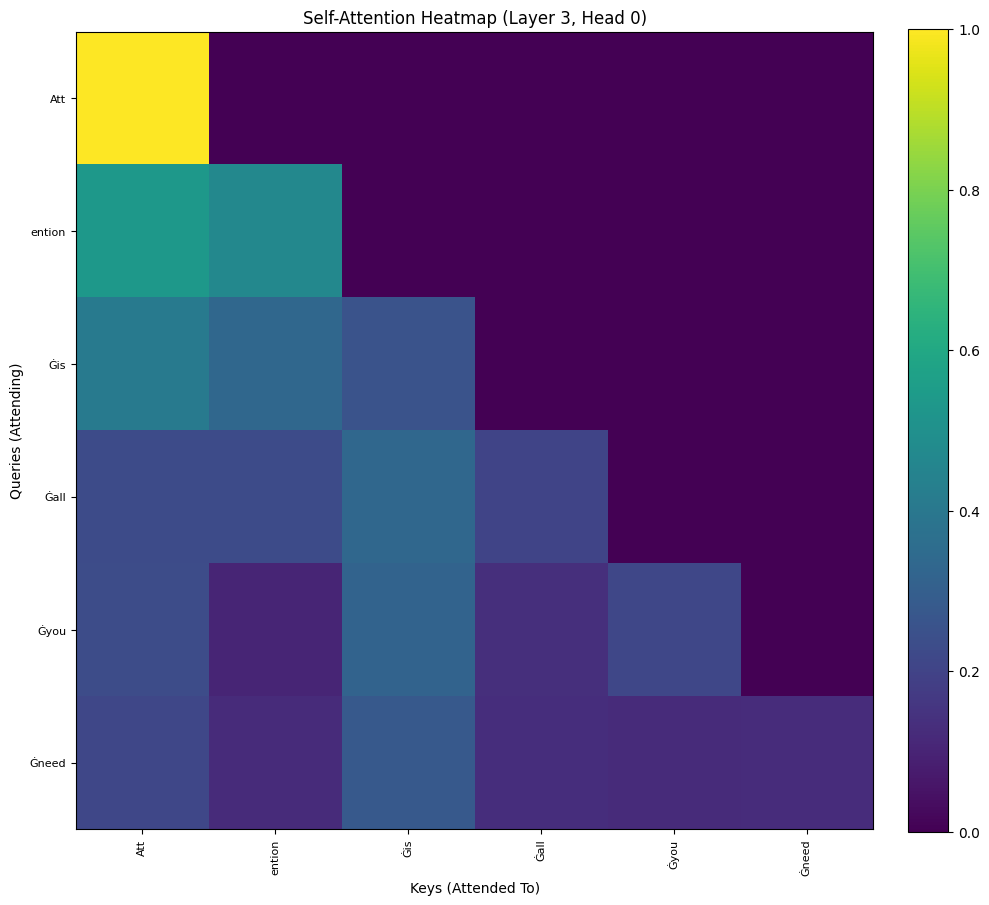

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# NOTE: This cell assumes TinyGPT class, tokenizer, and train_blocks are already loaded in memory.

# --- VITAL FIX: DEFINE DEVICE FIRST! ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Plotting on device: {device}")
# ----------------------------------------

# --- 1. SET UP THE INTERPRETABLE INPUT ---
INTERPRETABLE_SENTENCE = "Attention is all you need."
MAX_LEN = 128

# Use the GPT-2 tokenizer (tokenizer must be loaded from a previous cell)
tokenized_input = tokenizer(
    INTERPRETABLE_SENTENCE,
    return_tensors="pt",
    padding='max_length',
    truncation=True,
    max_length=MAX_LEN
)

sample_input_ids = tokenized_input['input_ids'].to(device)
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids[0].tolist())


# --- 2. MODEL SETUP (Using best performing medium configuration) ---
block_size = 128

# Load the model structure (TinyGPT class must be loaded from a previous cell)
model_to_plot = TinyGPT(
    vocab_size=len(tokenizer), d_model=256, n_layers=4, n_heads=4,
    d_ff=1024, max_len=block_size, dropout=0.1, pos_type="sinusoidal", lora_r=0
).to(device)

# NOTE: For a meaningful plot, you must load the weights from your best trained model here.
# E.g.: model_to_plot.load_state_dict(torch.load('best_tinygpt_weights.pt'))


# --- 3. FORWARD PASS AND EXTRACTION ---
TARGET_LAYER = 3  # The 4th layer (index 3) is a high-level layer
TARGET_HEAD = 0   # Use head 0 for simplicity

model_to_plot.eval()
with torch.no_grad():
    _ = model_to_plot(sample_input_ids[:, :-1])

# Extract the attention matrix
# This relies on the extraction logic implemented in your CausalSelfAttention class
attention_matrix = model_to_plot.blocks[TARGET_LAYER].attn.attention_weights.numpy()

# Determine the actual sequence length (remove padding)
seq_len = (sample_input_ids[0] != tokenizer.pad_token_id).sum().item()
matrix_size = seq_len - 1

# Trim tokens and matrix to the actual sequence length for clean plotting
tokens_trimmed = tokens[:matrix_size]
attention_matrix = attention_matrix[:matrix_size, :matrix_size]


# --- 4. PLOTTING ---
plt.figure(figsize=(10, 10))

# Create the heatmap
im = plt.imshow(attention_matrix, cmap='viridis', origin='upper', aspect='equal')

# Set labels using the trimmed, readable tokens
plt.xticks(range(matrix_size), tokens_trimmed, rotation=90, fontsize=8)
plt.yticks(range(matrix_size), tokens_trimmed, fontsize=8)

plt.xlabel('Keys (Attended To)')
plt.ylabel('Queries (Attending)')
plt.title(f'Self-Attention Heatmap (Layer {TARGET_LAYER}, Head {TARGET_HEAD})')

# Add color bar
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('interpretable_attention_heatmap.png')
print("Heatmap generation attempt successful.")

In [ ]:
# epochs = 5

# for epoch in range(epochs):
#     t0 = time.time()
#     train_loss = run_epoch(train_loader, train=True)
#     val_loss = run_epoch(val_loader, train=False)
#     elapsed = time.time() - t0

#     train_curve.append(train_loss)
#     val_curve.append(val_loss)

#     print(f"Epoch {epoch}: train {train_loss:.4f} | val {val_loss:.4f} | ppl {math.exp(val_loss):.1f} | time {elapsed:.1f}s")


In [ ]:
# plt.plot(train_curve, label="train")
# plt.plot(val_curve, label="val")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.legend()
# plt.title("TinyGPT Loss Curves")
# # plt.show()
